# IL2233 Lab 2 - ARIMA Model and Prediction

## Imports

In [2]:
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_excel, DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from numpy.fft import fft, rfft
from scipy.io import loadmat
from scipy.signal import spectrogram
from math import sqrt

**Helper functions**

In [16]:
# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
    fig.subplots_adjust()

    series.plot(ax=axes[0,0], kind='line', title='Line plot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,0], kind='box', title='Box plot')
    series.plot(ax=axes[1,1], kind='density', title='Density plot', xlabel='', ylabel='density')
    plotting.lag_plot(series, ax=axes[2,0])
    autocorrelation_plot(series, ax=axes[2,1])
    plot_pacf(series, lags=lags, ax=axes[3,0]);

def ljungbox(series: Series):
    return sm.stats.acorr_ljungbox(series)

def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')


def gen_arma(lagcoeffs_ar: list[int] = [], lagcoeffs_ma: list[int] = []):
    lagcoeffs_ar = np.r_[1, -np.array(lagcoeffs_ar)] if len(lagcoeffs_ar) > 0 else np.array([1])
    lagcoeffs_ma = np.r_[1, np.array(lagcoeffs_ma)] if len(lagcoeffs_ma) > 0 else np.array([1])

    proc = ArmaProcess(lagcoeffs_ar, lagcoeffs_ma)

    generated_time_series = proc.generate_sample(nsample=250)
    return generated_time_series, proc

# Task 1: Stationarity of AR models

<Axes: title={'center': '4)'}>

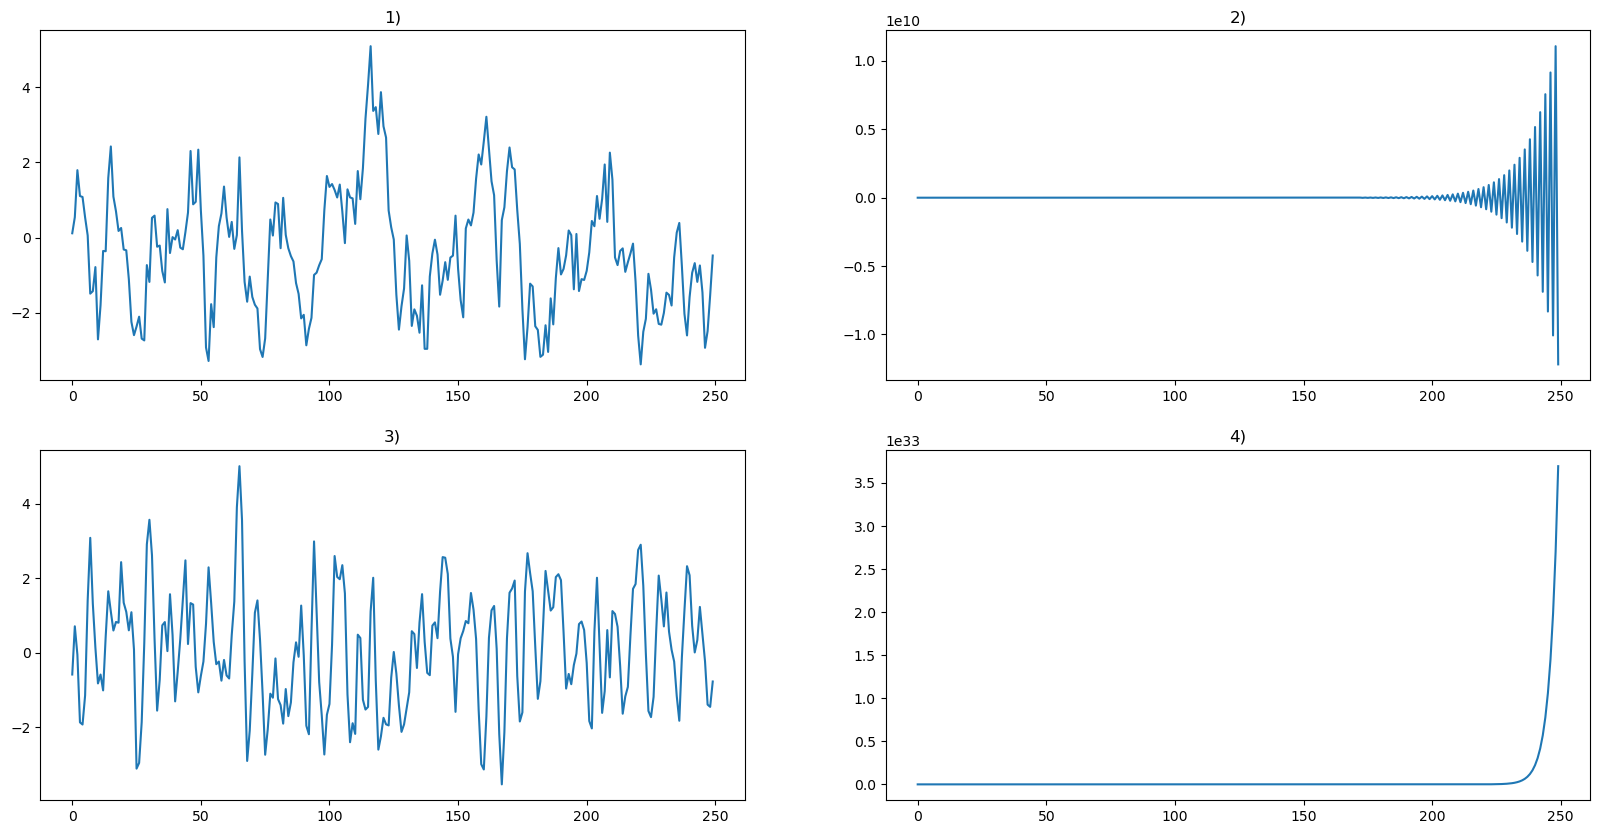

In [17]:
s1, p1 = gen_arma(lagcoeffs_ar=[0.8])
s2, p2 = gen_arma(lagcoeffs_ar=[-1.1])
s3, p3 = gen_arma(lagcoeffs_ar=[1, -0.5])
s4, p4 = gen_arma(lagcoeffs_ar=[1, 0.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust()
Series(s1).plot(ax=axes[0,0], kind='line', title='1)')
Series(s2).plot(ax=axes[0,1], kind='line', title='2)')
Series(s3).plot(ax=axes[1,0], kind='line', title='3)')
Series(s4).plot(ax=axes[1,1], kind='line', title='4)')

**Judging visually:**

 None of the time series seem to be weakly stationary. In the case of 2), the mean may be constant but the variance is not.
We find that 3) could be potentially stationary, but further tests are required to determine this.

**Judging by coefficients:**

To determine if the generated time series are stationary we can check the following constraints on the coefficients:
- For p = 1: <u>−1 < $\phi_1$ < 1</u>.
- For p = 2: <u>−1 < $\phi_2$ < 1</u> AND <u>$\phi_2$ + $\phi_1$ < 1</u> AND <u>$\phi_2$ − $\phi_1$ < 1</u>.

- 1) AR(1) = $0.8x_{t-1} + \epsilon_t           \rightarrow -1 < \phi_1 = 0.8 < 1$, which **fulfills** the stationarity condition for $p = 1$
- 2) AR(1) = $-1.1x_{t-1} + \epsilon_t          \rightarrow -1 > \phi_1 = -1.1$, which does **not fulfill** the stationarity condition for $p = 1$
- 3) AR(2) = $1x_{t-1} - 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = -0.5 < 1$, $\phi_2 + \phi_1 = 0.5 < 1$, and $\phi_2 - \phi_1 = 0.5 < 1$, which **fulfills** the stationarity condition for $p = 2$
- 4) AR(2) = $1x_{t-1} + 0.5x_{t-2} \epsilon_t  \rightarrow -1 < \phi_2 = 0.5 < 1$, $\phi_2 + \phi_1 = 1.5 > 1$, and $\phi_2 - \phi_1 = -0.5 < 1$, which does **not fulfill** the stationarity condition as the second criteria is not fulfilled

**Built-in function in statsmodels:**

From the output below, we validate that manual stationarity calculations were correct.

In [21]:
print(f"AR process 1 is stationary: {p1.isstationary}")
print(f"AR process 2 is stationary: {p2.isstationary}")
print(f"AR process 3 is stationary: {p3.isstationary}")
print(f"AR process 4 is stationary: {p4.isstationary}")

AR process 1 is stationary: True
AR process 2 is stationary: False
AR process 3 is stationary: True
AR process 4 is stationary: False


**Augmented Dickey-Fuller Test:**

One final stationarity test is done on the time series applying the ADF test. For each of the test outputs, we check if the ADF-statistic is less than all the critical values and also if the p-value is less than 0.5.

Our findings 

In [31]:
adfuller_test(Series(s1))
print("-"*40)
adfuller_test(Series(s2))
print("-"*40)
adfuller_test(Series(s3))
print("-"*40)
adfuller_test(Series(s4))

ADF Statistic: -4.7538220233235275
p-value: 6.659774730746343e-05
Critial Values:
1%, -3.4568881317725864
Critial Values:
5%, -2.8732185133016057
Critial Values:
10%, -2.5729936189738876
----------------------------------------
ADF Statistic: -53969335247.91278
p-value: 0.0
Critial Values:
1%, -3.4568881317725864
Critial Values:
5%, -2.8732185133016057
Critial Values:
10%, -2.5729936189738876
----------------------------------------
ADF Statistic: -12.011068787552565
p-value: 3.18001715963096e-22
Critial Values:
1%, -3.4569962781990573
Critial Values:
5%, -2.8732659015936024
Critial Values:
10%, -2.573018897632674
----------------------------------------
ADF Statistic: 4.772079650374936e+16
p-value: 1.0
Critial Values:
1%, -3.458731141928624
Critial Values:
5%, -2.8740258764297293
Critial Values:
10%, -2.5734243167124093
